#1. Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate
import os
import numpy as np
import pandas as pd
import random
import pickle

#2. Load Dataset

In [ ]:
train_dir = '/content/drive/MyDrive/tomato_dataset/train'
val_dir = '/content/drive/MyDrive/tomato_dataset/validation'

#3. Augmentasi and Preprocessing Data

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale = 1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'categorical',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 1354 images belonging to 6 classes.
Found 472 images belonging to 6 classes.


#4. Model Building & Fitting

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the model and training state
checkpoint_path = "/content/drive/My Drive/model_checkpoint_2.h5"
training_state_path = "/content/drive/My Drive/training_state_2.pkl"

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])

    return model

# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 10,
                               restore_best_weights=True)

# Check Point
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch'
)

# Save Training State
def save_training_state(epoch, optimizer):
    optimizer_config = optimizer.get_config()
    state = {'epoch': epoch, 'optimizer': optimizer.get_config()}
    with open(training_state_path, 'wb') as f:
        pickle.dump(state, f)

# Callback to save training state
class TrainingStateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        save_training_state(epoch, self.model.optimizer)

# Function to load training status
def load_training_state():
    with open(training_state_path, 'rb') as f:
        state = pickle.load(f)
    return state

# Option to start or continue training
resume_training = True  # Change to True if continuing training

if resume_training:
    # Load model from checkpoint
    model = create_model()
    model.load_weights(checkpoint_path)

    # Load training status
    state = load_training_state()
    optimizer_config = state['optimizer']
    model.optimizer = tf.keras.optimizers.Adam.from_config(optimizer_config)
    initial_epoch = state['epoch'] + 1

    # Continue training
    history = model.fit(train_generator,
                        steps_per_epoch=train_generator.samples // train_generator.batch_size,
                        validation_data=val_generator,
                        validation_steps=val_generator.samples // val_generator.batch_size,
                        epochs=110,
                        initial_epoch=initial_epoch,
                        callbacks=[early_stopping,
                                  checkpoint_callback,
                                  TrainingStateCallback()])
else:
    # Start training from scratch
    model = create_model()
    history = model.fit(train_generator,
                        steps_per_epoch=train_generator.samples // train_generator.batch_size,
                        validation_data=val_generator,
                        validation_steps=val_generator.samples // val_generator.batch_size,
                        epochs=100,
                        callbacks=[early_stopping,
                                   checkpoint_callback,
                                   TrainingStateCallback()])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 101/110
42/42 [==============================] - 306s 7s/step - loss: 0.3313 - accuracy: 0.8835 - val_loss: 0.7563 - val_accuracy: 0.7768
Epoch 102/110
42/42 [==============================] - 305s 7s/step - loss: 0.2659 - accuracy: 0.9017 - val_loss: 0.6542 - val_accuracy: 0.7924
Epoch 103/110
42/42 [==============================] - 300s 7s/step - loss: 0.2658 - accuracy: 0.9017 - val_loss: 0.5708 - val_accuracy: 0.8170
Epoch 104/110
42/42 [==============================] - 306s 7s/step - loss: 0.2549 - accuracy: 0.9047 - val_loss: 0.6641 - val_accuracy: 0.8058
Epoch 105/110
42/42 [==============================] - 310s 7s/step - loss: 0.2830 - accuracy: 0.9024 - val_loss: 0.7198 - val_accuracy: 0.7857
Epoch 106/110
42/42 [==============================] - 302s 7s/step - loss: 0.2736 - accuracy: 0.8971 - val_loss: 0.5495 - val_accuracy: 0.8304
Epoch 1

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 74, 74, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 36, 36, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 17, 17, 256)      

#6. Evaluasi Model

In [ ]:
# Evaluation of accuracy on the same batch
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
print(f"Train Accuracy: {train_accuracy*100:.2f}%")

val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

42/42 [==============================] - 93s 2s/step - loss: 0.1678 - accuracy: 0.9382
Train Accuracy: 93.82%
14/14 [==============================] - 27s 2s/step - loss: 0.5077 - accuracy: 0.8281
Validation Accuracy: 82.81%


In [ ]:
# Overall evaluation
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

43/43 [==============================] - 91s 2s/step - loss: 0.1763 - accuracy: 0.9417
Training Accuracy: 94.17%
15/15 [==============================] - 28s 2s/step - loss: 0.5306 - accuracy: 0.8199
Validation Accuracy: 81.99%


#7. Visualization of training results

Available keys in history.history: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


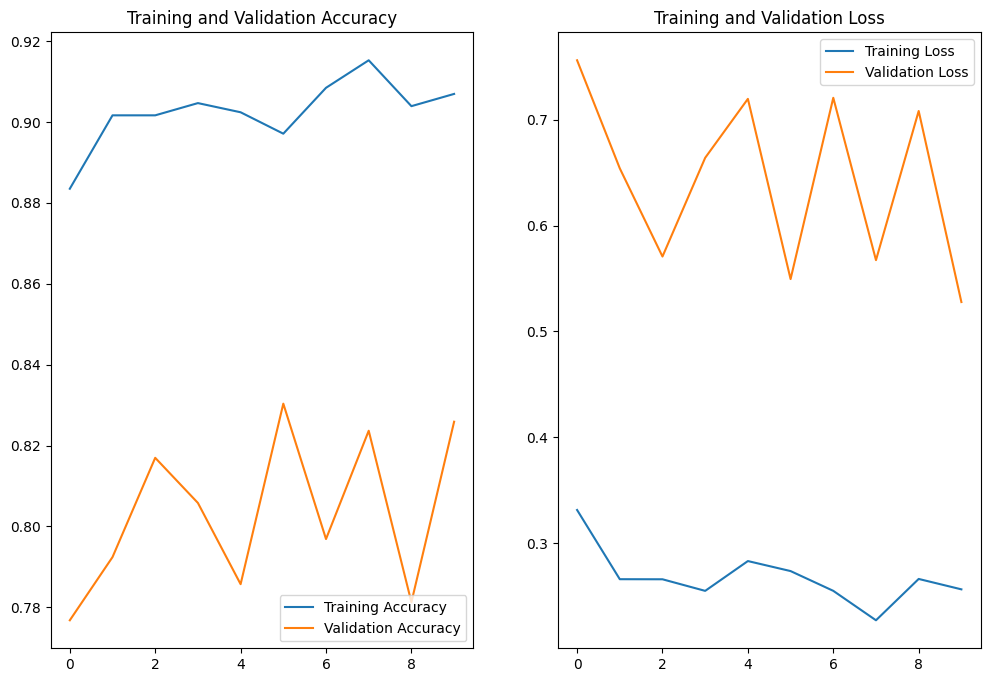

In [ ]:
def get_metric_values(history, metric):
    return history.history.get(metric, [])

print("Available keys in history.history:", history.history.keys())

acc = get_metric_values(history, 'accuracy')
val_acc = get_metric_values(history, 'val_accuracy')
loss = get_metric_values(history, 'loss')
val_loss = get_metric_values(history, 'val_loss')

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(1, 2, 1)
if acc and val_acc:
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
else:
    plt.title('Accuracy data not available')

# Plot loss
plt.subplot(1, 2, 2)
if loss and val_loss:
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
else:
    plt.title('Loss data not available')

plt.show()


#8. Save Model

In [ ]:
# Save the entire model to an HDF5 file
model.save('model.h5')
print("Model disimpan sebagai model.h5")

# Save the model architecture to a JSON file
json_config = model.to_json()
with open('model_config.json', 'w') as json_file:
    json_file.write(json_config)
print("Arsitektur model disimpan sebagai model_config.json")

# Save model weights to HDF5 file
model.save_weights('model_weights.h5')
print("Bobot model disimpan sebagai model_weights.h5")

# Load the model architecture from the JSON file
with open('model_config.json', 'r') as json_file:
    json_config = json_file.read()
new_model = model_from_json(json_config)
print("Arsitektur model dimuat dari model_config.json")

# Load model weights from HDF5 file
new_model.load_weights('model_weights.h5')
print("Bobot model dimuat dari model_weights.h5")

# Convert model weights to binary format and save as .bin file
weights = model.get_weights()
with open('model_weights.bin', 'wb') as bin_file:
    for weight in weights:
        bin_file.write(weight.tobytes())
print("Bobot model disimpan sebagai model_weights.bin")

# Loads model weights from  .bin file
def load_weights_from_bin(model, bin_path):
    weights = model.get_weights()
    with open(bin_path, 'rb') as bin_file:
        for i in range(len(weights)):
            weights[i] = np.frombuffer(bin_file.read(weights[i].nbytes), dtype=weights[i].dtype).reshape(weights[i].shape)
    model.set_weights(weights)

load_weights_from_bin(new_model, 'model_weights.bin')
print("Bobot model dimuat dari model_weights.bin")

# Evaluate newly loaded models to ensure compliance
# new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# evaluation = new_model.evaluate(validation_data)
# print(f"Evaluation of model accuracy: {evaluation[1]}")

Model disimpan sebagai model.h5
Arsitektur model disimpan sebagai model_config.json
Bobot model disimpan sebagai model_weights.h5
Arsitektur model dimuat dari model_config.json
Bobot model dimuat dari model_weights.h5
Bobot model disimpan sebagai model_weights.bin
Bobot model dimuat dari model_weights.bin


#9. Conver Model to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras model.h5 model_tfjs

In [ ]:
import shutil

shutil.make_archive('model_tfjs', 'zip', 'model_tfjs')

In [ ]:
from google.colab import files
files.download('model_tfjs.zip')

#10. Load and use the model

In [ ]:
model = load_model('/content/model.h5')
uploaded = files.upload()
class_name = ['Blossom-end-rottation', 'Cracking', 'Healthy', 'Not-tomato', 'Spliting', 'Sun-scaled']

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  predictions = model.predict(x)

  predicted_class_index = np.argmax(predictions)

  predicted_class_name = class_name[predicted_class_index]

  print("Predicted class for", fn, ":", predicted_class_name)